Fitting over both radial and angular direction. This is needed for the case of Kerr.

# Load Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnm
import glob
import h5py
from scipy.linalg import lstsq
from matplotlib.colors import LogNorm
from numpy.fft import *

# Load radial profile and data

In [2]:
# black hole spin
a = 0.7
# azimuthal mode
m = 2

## Scattering data from the TeukEvolution.jl

In [3]:
files = glob.glob("../data/TeukEvolution/scattering/high_a0.7_scattering/a0.7_nx512_ny40.npz")

psi4 = np.load(files[0])['psi4_l']
dpsi4 = np.load(files[0])['dt_psi4_l']
t = np.load(files[0])['time']
r = np.load(files[0])['rads']

In [4]:
# The two-dimensional domain of data
R, T = np.meshgrid(r, t)
nr, nt = r.shape[0], t.shape[0]

In [5]:
psi4.shape

(10, 641, 512)

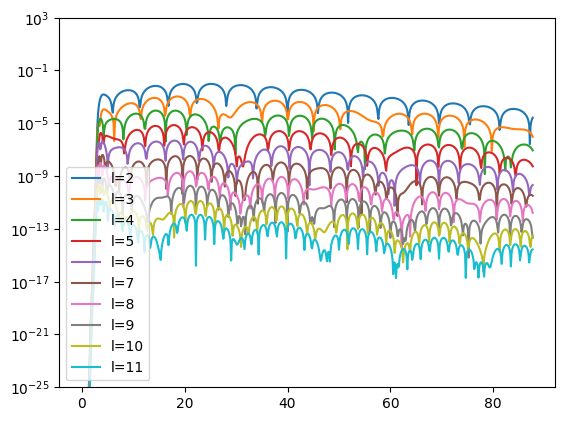

In [6]:
i=0
# Lables for l modes
ls = np.arange(psi4.shape[0])+m
for l in ls:
    plt.plot(t,np.abs(np.real(psi4[i][:,0])),label='l=%s'%l)
    i+=1

plt.ylim(1e-25,1e3)
plt.yscale('log')
plt.legend()

prograde modes

In [7]:
# Which qnm l numbers to fit?
ls_fit = np.arange(3)+m

In [9]:
rs_pros = []
radial_wf_pros = []
omegas_pros = []
radial_coeff_pros = []
angular_coeff_pros = []
for l in ls_fit:
    file = h5py.File("../data/qnm/a%s_l%s_m%s.h5"%(a,l,m),'r')
    rs_pro = []
    radial_wf_pro = []
    omegas_pro = []
    radial_coeff_pro = []
    angular_coeff_pro = []
    # Load Overtones
    if l==2:
        for n in range(6):
            rs_pro.append(np.array(file['[n=%s]'%n]['rvals']))
            radial_wf_pro.append(np.array(file['[n=%s]'%n]['radial_func']))
            radial_coeff_pro.append(np.array(file['[n=%s]'%n]['radial_coef']))
            omegas_pro.append(np.array(file['[n=%s]'%n]['omega']))
            angular_coeff_pro.append(np.array(file['[n=%s]'%n]['angular_coef']))
            angular_coeff_pro[n]*=(-1)**np.arange(angular_coeff_pro[n].shape[0])
    else:
        for n in range(2):
            rs_pro.append(np.array(file['[n=%s]'%n]['rvals']))
            radial_wf_pro.append(np.array(file['[n=%s]'%n]['radial_func']))
            radial_coeff_pro.append(np.array(file['[n=%s]'%n]['radial_coef']))
            omegas_pro.append(np.array(file['[n=%s]'%n]['omega']))
            angular_coeff_pro.append(np.array(file['[n=%s]'%n]['angular_coef']))
            angular_coeff_pro[n]*=(-1)**np.arange(angular_coeff_pro[n].shape[0])
    rs_pros.append(rs_pro)
    radial_wf_pros.append(radial_wf_pro)
    omegas_pros.append(omegas_pro)
    radial_coeff_pros.append(radial_coeff_pro)
    angular_coeff_pros.append(angular_coeff_pro)

retrograde modes

In [10]:
rs_retros = []
radial_wf_retros = []
omegas_retros = []
radial_coeff_retros = []
angular_coeff_retros = []
for l in ls_fit:
    file = h5py.File("../data/qnm/a%s_l%s_m-%s.h5"%(a,l,m),'r')
    rs_retro = []
    radial_wf_retro = []
    omegas_retro = []
    radial_coeff_retro = []
    angular_coeff_retro = []
    # Load Overtones
    if l==2:
        for n in range(6):
            rs_retro.append(np.array(file['[n=%s]'%n]['rvals']))
            radial_wf_retro.append(np.conjugate(np.array(file['[n=%s]'%n]['radial_func'])))
            radial_coeff_retro.append(np.array(file['[n=%s]'%n]['radial_coef']))
            omegas_retro.append(-np.conjugate(np.array(file['[n=%s]'%n]['omega'])))
            angular_coeff_retro.append(np.array(file['[n=%s]'%n]['angular_coef']))
    else:
        for n in range(2):
            rs_retro.append(np.array(file['[n=%s]'%n]['rvals']))
            radial_wf_retro.append(np.conjugate(np.array(file['[n=%s]'%n]['radial_func'])))
            radial_coeff_retro.append(np.array(file['[n=%s]'%n]['radial_coef']))
            omegas_retro.append(-np.conjugate(np.array(file['[n=%s]'%n]['omega'])))
            angular_coeff_retro.append(np.array(file['[n=%s]'%n]['angular_coef']))
    rs_retros.append(rs_retro)
    radial_wf_retros.append(radial_wf_retro)
    omegas_retros.append(omegas_retro)
    radial_coeff_retros.append(radial_coeff_retro)
    angular_coeff_retros.append(angular_coeff_retro)

In [11]:
# Interpolation functions for radial quasinormal eigenfunctions
rmax = (1 / (a**2)) * (1 - np.sqrt(1 - ((a)**2)))
qne_pros = []
qne_retros = []

for i in range(len(ls_fit)):
    qne_pro = []
    qne_retro = []
    if ls[i] == 2:
        for n in range(6):
            qne_pro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_pros[i][n]/radial_wf_pros[i][n][-1],domain=[0,rmax]))
            qne_retro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_retros[i][n]/radial_wf_retros[i][n][-1],domain=[0,rmax]))
    else:
        for n in range(2):
            qne_pro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_pros[i][n]/radial_wf_pros[i][n][-1],domain=[0,rmax]))
            qne_retro.append(np.polynomial.chebyshev.Chebyshev(radial_coeff_retros[i][n]/radial_wf_retros[i][n][-1],domain=[0,rmax]))
    qne_pros.append(qne_pro)
    qne_retros.append(qne_retro)

We note that both the prograde and retrograde radial eigenfunctions are recovered!

# Excitation Amplitude and Fitting

## Excitation Matrix construction

In [12]:
def excitation_matrix(r,modes,ls,ls_fit):
    # the l=2 overtones to be fitted can be specified by "modes"
    # Fitting the fundamental and first overtone of the
    # higher harmonics specified in ls_fit
    # Same number of overtones for prograde and retrograde modes
    # ls labels which ls modes in the data to fit
    M = np.zeros((r.shape[0]*2*len(ls),len(modes)*2+4*(len(ls_fit)-1)),dtype='complex128')
    s = r.shape[0]
    for i in range(len(ls_fit)):
        print(ls_fit[i])

        # l=2 modes
        if ls_fit[i]==2:
            for m in modes:
                for l in range(len(ls)):
                    # prograde wavefunction and time derivative
                    M[2*l*s:(2*l+1)*s,m] = qne_pros[i][m](r)/qne_pros[i][m](0)*angular_coeff_pros[i][m][l]
                    M[(2*l+1)*s:(2*l+2)*s,m] = -1j*qne_pros[i][m](r)/qne_pros[i][m](0)*omegas_pros[i][m]*angular_coeff_pros[i][m][l]
                    # retrograde wavefunction and time derivative
                    M[2*l*s:(2*l+1)*s,len(modes)+m] = qne_retros[i][m](r)/qne_retros[i][m](0)*angular_coeff_retros[i][m][l]
                    M[(2*l+1)*s:(2*l+2)*s,len(modes)+m] = -1j*qne_retros[i][m](r)/qne_retros[i][m](0)*omegas_retros[i][m]*angular_coeff_retros[i][m][l]
        # l>2 modes
        else:
            for m in range(2):
                for l in range(len(ls)):
                    # prograde wavefunction and time derivative
                    M[2*l*s:(2*l+1)*s,2*len(modes)+4*(i-1)+m] = qne_pros[i][m](r)/qne_pros[i][m](0)*angular_coeff_pros[i][m][l]
                    M[(2*l+1)*s:(2*l+2)*s,2*len(modes)+4*(i-1)+m] = -1j*qne_pros[i][m](r)/qne_pros[i][m](0)*omegas_pros[i][m]*angular_coeff_pros[i][m][l]
                    # retrograde wavefunction and time derivative
                    M[2*l*s:(2*l+1)*s,2*len(modes)+4*(i-1)+2+m] = qne_retros[i][m](r)/qne_retros[i][m](0)*angular_coeff_retros[i][m][l]
                    M[(2*l+1)*s:(2*l+2)*s,2*len(modes)+4*(i-1)+2+m] = -1j*qne_retros[i][m](r)/qne_retros[i][m](0)*omegas_retros[i][m]*angular_coeff_retros[i][m][l]
    return M

In [13]:
m

2

In [25]:
# Construct design matrix with 3 prograde modes 
# and 3 retrograde modes
m=2
modes = range(5)
ls_fit2 = np.arange(3)+m
ls2 = np.arange(5)+m

M = excitation_matrix(r,modes,ls2,ls_fit2)
Minv = np.linalg.pinv(M)

2
3
4


In [26]:
Z = psi4[:len(ls2)]
dZ = dpsi4[:len(ls2)]

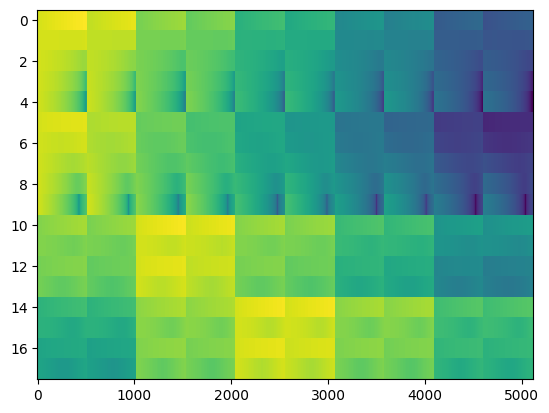

In [27]:
plt.imshow(np.log(np.abs(M).T),aspect='auto',interpolation='none')

In [28]:
rhs = np.swapaxes(np.append(Z,dZ,axis=-1),0,1).reshape(Z.shape[1],2*Z.shape[0]*Z.shape[2])

In [29]:
rhs.shape

(641, 5120)

In [30]:
M.shape

(5120, 18)

In [31]:
# Compute excitation factors

ext_xs = []
for i in range(t.shape[0]):
    x = np.dot(Minv,rhs[i])
    ext_xs.append(x)
ext_xs = np.array(ext_xs)

In [32]:
# time where the amplitude of psi4 peaks at null infinity 
# and at horizon
tmax = t[np.abs(Z[0,:,0])==np.abs(Z[0,:,0]).max()][0]
tmax_horizon = t[np.abs(Z[0,:,-1])==np.abs(Z[0,:,-1]).max()][0]

In [33]:
tmax

22.05663275711975

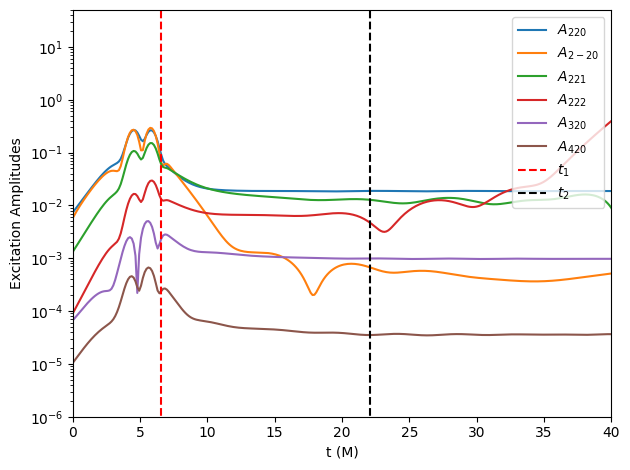

In [34]:
for m in range(3):
    plt.plot(t,np.abs(ext_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(t-tmax))),label='$A_{22%s}$'%m)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
    if m==0:
        plt.plot(t,np.abs(ext_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(t-tmax))),label='$A_{2-2%s}$'%m)
#for m in range(1):
    
plt.plot(t,np.abs(ext_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(t-tmax))),label='$A_{32%s}$'%0)
plt.plot(t,np.abs(ext_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(t-tmax))),label='$A_{42%s}$'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
plt.vlines(tmax_horizon,0,100,'r','--',label='$t_{1}$')
plt.vlines(tmax,0,100,'k','--',label='$t_{2}$')

    #plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)
plt.yscale('log')
plt.ylim(1e-6,5e1)
plt.legend(loc='upper right')
plt.xlim(0,40)
plt.xlabel("t (M)")
plt.ylabel("Excitation Amplitudes")
#plt.title("a=0.5 scattering")
plt.tight_layout()

plt.savefig("../figures/excitation_a%s.png"%a,dpi=300)

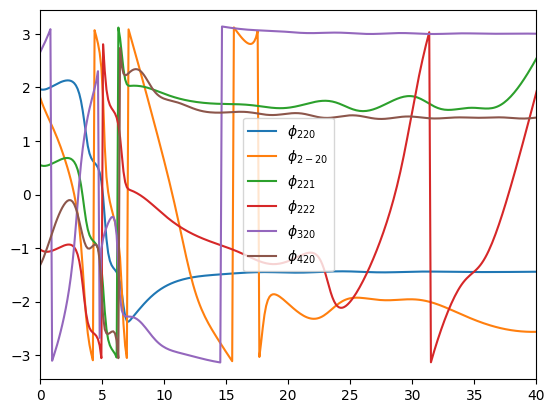

In [35]:

for m in range(3):
    plt.plot(t,np.angle(ext_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(t-tmax))),label='$\phi_{22%s}$'%m)
    if m==0:
        plt.plot(t,np.angle(ext_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(t-tmax))),label='$\phi_{2-2%s}$'%m)
#for m in range(1):

plt.plot(t,np.angle(ext_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(t-tmax))),label='$\phi_{32%s}$'%0)
plt.plot(t,np.angle(ext_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(t-tmax))),label='$\phi_{42%s}$'%0)
    #plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)

#plt.yscale('log')
plt.xlim(0,40)
#plt.ylim(1e-5,1e2)
plt.legend()
#plt.title("a=0.5 scattering phase")
plt.savefig("../figures/excitation_a%s_phi.png"%i,dpi=300)

In [36]:
def qnm_pro(r,t,A,l,n):
    l-=2
    return (np.outer(A*np.exp(-1j*(omegas_pros[l][n]*t)),qne_pros[l][n](r)/qne_pros[l][n](0)))
def qnm_retro(r,t,A,l,n):
    l-=2
    return (np.outer(A*np.exp(-1j*(omegas_retros[l][n]*t)),qne_retros[l][n](r)/qne_retros[l][n](0)))

# Fitting

In [37]:
def construct_matrix_and_fit(Z,r,t,t0,modes,ls,ls_fit):
    M = np.zeros((t[t>=t0].shape[0]*r.shape[0]*len(ls),2*len(modes)+4*(len(ls_fit)-1)),dtype='complex128')
    
    R, T = np.meshgrid(r, t)
    s = t[t>=t0].shape[0]*r.shape[0]
    for i in range(len(ls_fit)):
        # l=2 modes
        if ls_fit[i]==2:
            for m in modes:
                for l in range(len(ls)):
                    M[l*s:(l+1)*s,m] = qnm_pro(r,t[t>=t0],1,ls_fit[i],m).ravel()*angular_coeff_pros[i][m][l]
                    M[l*s:(l+1)*s,len(modes)+m] = qnm_retro(r,t[t>=t0],1,ls_fit[i],m).ravel()*angular_coeff_retros[i][m][l]
        else:
            for m in range(2):
                for l in range(len(ls)):
                    M[l*s:(l+1)*s,2*len(modes)+2*(i-1)+m] = qnm_pro(r,t[t>=t0],1,ls_fit[i],m).ravel()*angular_coeff_pros[i][m][l]
                    M[l*s:(l+1)*s,2*len(modes)+2*(i-1)+m+2] = qnm_retro(r,t[t>=t0],1,ls_fit[i],m).ravel()*angular_coeff_retros[i][m][l]
    rhs = np.ravel(Z[0][T>=t0])
    for l in range(1,len(ls)):
        rhs = np.append(rhs,Z[l][T>=t0].ravel())
    x,residual,rank,s = lstsq(M,rhs)
    #residual = np.mean(np.abs(np.dot(M,x)-Z[T>=t0].ravel()))
    return x,residual

In [39]:
t1 = t[::8]

In [40]:
ls_fit3 = np.arange(3)+2
ls3 = np.arange(3)+2
fit_xs = []
fit_residuals = []
for t0 in t1:
    x,residual = construct_matrix_and_fit(Z,r,t,t0,modes,ls3,ls_fit3)
    fit_xs.append(x)
    fit_residuals.append(residual)
    print(t0/t.max())
fit_xs = np.array(fit_xs)

0.0
0.012499999999999999
0.024999999999999998
0.0375
0.049999999999999996
0.0625
0.075
0.0875
0.09999999999999999
0.1125
0.125
0.13749999999999998
0.15
0.1625
0.175
0.1875
0.19999999999999998
0.21250000000000002
0.225
0.23750000000000002
0.25
0.2625
0.27499999999999997
0.28750000000000003
0.3
0.3125
0.325
0.3375
0.35
0.3625
0.375
0.38749999999999996
0.39999999999999997
0.41250000000000003
0.42500000000000004
0.43750000000000006
0.45
0.4625
0.47500000000000003
0.4875
0.5
0.5125
0.525
0.5375
0.5499999999999999
0.5625
0.5750000000000001
0.5875
0.6
0.6125
0.625
0.6375000000000001
0.65
0.6625
0.675
0.6875
0.7
0.7125
0.725
0.7375
0.75
0.7625000000000001
0.7749999999999999
0.7875
0.7999999999999999
0.8125
0.8250000000000001
0.8375
0.8500000000000001
0.8624999999999999
0.8750000000000001
0.8875
0.9
0.9125
0.925
0.9375
0.9500000000000001
0.9624999999999999
0.975
0.9875
1.0


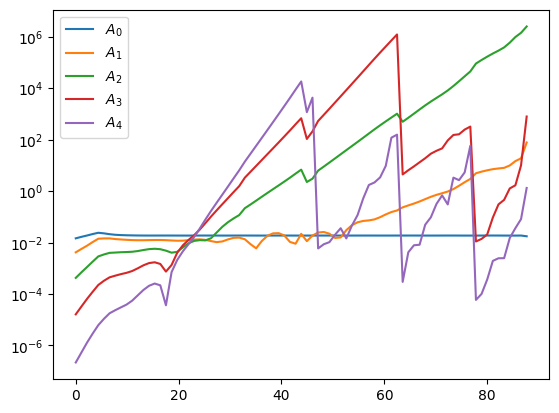

In [41]:
for m in modes:
    plt.plot(t1,np.abs(fit_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(-tmax))),label='$A_{%s}$'%m)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-5,1)
#plt.xlim(0,30)

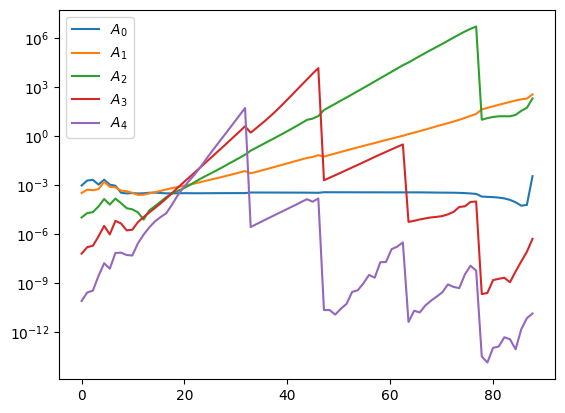

In [42]:
for m in modes:
    plt.plot(t1,np.abs(fit_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(-tmax))),label='$A_{%s}$'%m)
plt.legend()
plt.yscale('log')
#plt.ylim(1e-5,1)
#plt.xlim(0,30)

Text(0.5, 1.0, 'prograde modes')

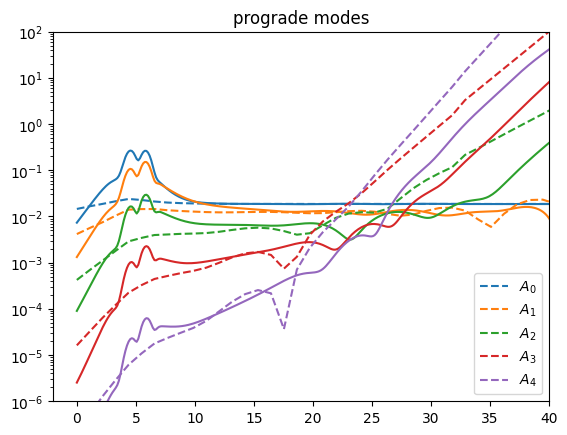

In [43]:
# Dashed lines are from fitting and the solid lines 
# are from the excitation factor calculation. 
# They agree perfectly!
for m in modes:
    plt.plot(t1,np.abs(fit_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(-tmax))),'--',label='$A_{%s}$'%m)
    plt.plot(t,np.abs(ext_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(t-tmax))),c='C%s'%m)
plt.yscale('log')
plt.xlim(-2,40)
plt.ylim(1e-6,1e2)
plt.legend()
plt.title("prograde modes")

Text(0.5, 1.0, 'retrograde modes')

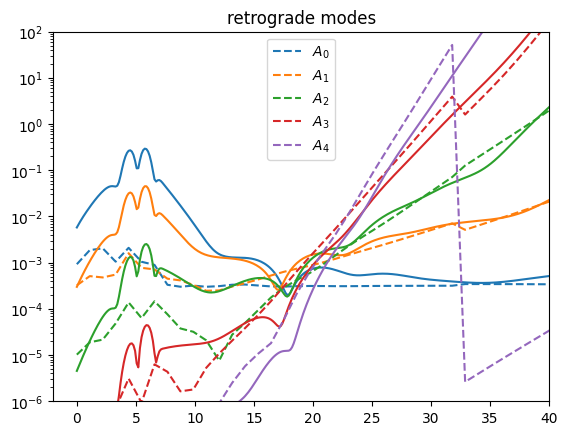

In [44]:
# Dashed lines are from fitting and the solid lines 
# are from the excitation factor calculation. 
# They agree perfectly!
for m in modes:
    plt.plot(t1,np.abs(fit_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(-tmax))),'--',label='$A_{%s}$'%m)
    plt.plot(t,np.abs(ext_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(t-tmax))),c='C%s'%m)
plt.yscale('log')
plt.xlim(-2,40)
plt.ylim(1e-6,1e2)
plt.legend()
plt.title("retrograde modes")

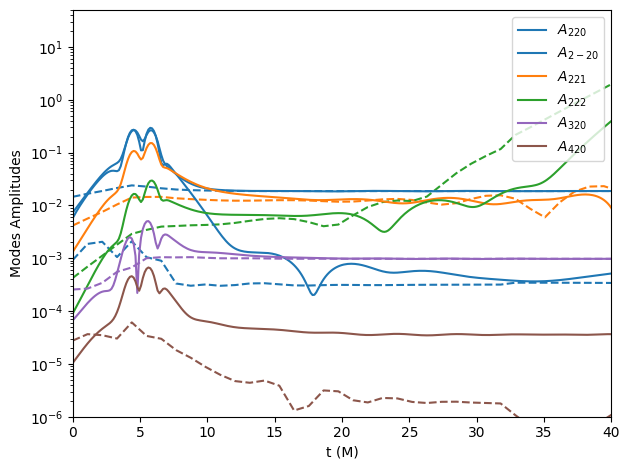

In [45]:
for m in range(3):
    plt.plot(t1,np.abs(fit_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(-tmax))),'--',c='C%s'%m)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
    if m==0:
        plt.plot(t1,np.abs(fit_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(-tmax))),'--',c='C%s'%m)
#for m in range(1):
for m in range(3):
    plt.plot(t,np.abs(ext_xs[:,m]*np.exp(1j*omegas_pros[0][m]*(t-tmax))),c='C%s'%m,label='$A_{22%s}$'%m)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
    if m==0:
        plt.plot(t,np.abs(ext_xs[:,len(modes)+m]*np.exp(1j*omegas_retros[0][m]*(t-tmax))),c='C%s'%m,label='$A_{2-2%s}$'%m)
#for m in range(1):
    
plt.plot(t,np.abs(ext_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(t-tmax))),c='C%s'%4,label='$A_{32%s}$'%0)
plt.plot(t,np.abs(ext_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(t-tmax))),c='C%s'%5,label='$A_{42%s}$'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
    
plt.plot(t1,np.abs(fit_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(-tmax))),'--',c='C%s'%4)
plt.plot(t1,np.abs(fit_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(-tmax))),'--',c='C%s'%5)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)
#plt.vlines(tmax_horizon,0,100,'r','--',label='$t_{1}$')
#plt.vlines(tmax,0,100,'k','--',label='$t_{2}$')

    #plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)
plt.yscale('log')
plt.ylim(1e-6,5e1)
plt.legend(loc='upper right')
plt.xlim(0,40)
plt.xlabel("t (M)")
plt.ylabel("Modes Amplitudes")
#plt.title("a=0.5 scattering")
plt.tight_layout()

plt.savefig("../figures/fit_a%s.png"%a,dpi=300)

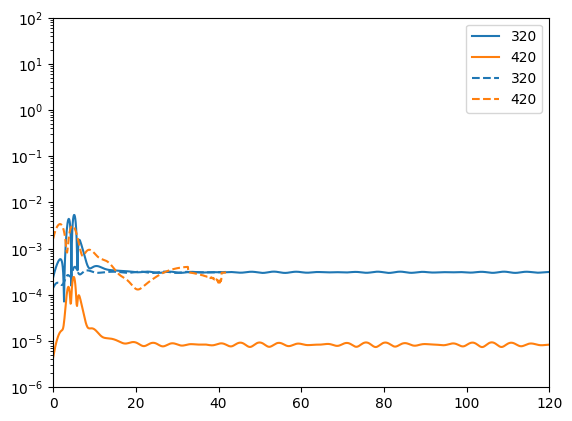

In [36]:
plt.plot(t,np.abs(ext_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(t-tmax))),c='C%s'%0,label='32%s'%0)
plt.plot(t,np.abs(ext_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(t-tmax))),c='C%s'%1,label='42%s'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)


plt.plot(t1,np.abs(fit_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(-tmax))),'--',c='C%s'%0,label='32%s'%0)
plt.plot(t1,np.abs(fit_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(-tmax))),'--',c='C%s'%1,label='42%s'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)


    #plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)

plt.yscale('log')
plt.xlim(0,120)
plt.ylim(1e-6,1e2)
plt.legend()

In [37]:
fit_xs.shape

(400, 18)

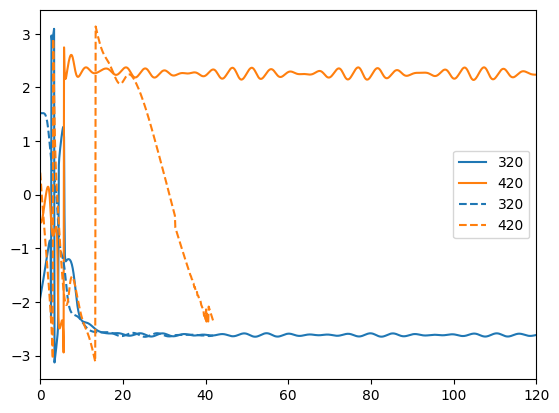

In [38]:

plt.plot(t,np.angle(ext_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(t-tmax))),c='C%s'%0,label='32%s'%0)
plt.plot(t,np.angle(ext_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(t-tmax))),c='C%s'%1,label='42%s'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)


plt.plot(t1,np.angle(fit_xs[:,2*len(modes)]*np.exp(1j*omegas_pros[1][0]*(-tmax))),'--',c='C%s'%0,label='32%s'%0)
plt.plot(t1,np.angle(fit_xs[:,2*len(modes)+4]*np.exp(1j*omegas_pros[2][0]*(-tmax))),'--',c='C%s'%1,label='42%s'%0)#*np.exp(1j*omegas_pro[m]*(t-tmax))),label='22%s'%m)


#plt.plot(t,np.abs(xs[:,m+len(modes)]*np.exp(1j*omegas_retro[m]*(t-tmax))),label='22%s retrograde'%m)

#plt.yscale('log')
plt.xlim(0,120)
#plt.ylim(1e-6,1e2)
plt.legend()